In [1]:
import xarray
import fsspec
import numpy as np
import s3fs
import proplot
import os

from matplotlib import pyplot as plt
import pandas

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
import sys
sys.path.append('/tube1/cha674/CARS_2022/cars-v2/wodpy/wodpy')
import wodnc

In [3]:
START_YEAR = 2010
END_YEAR   = 2011

In [ ]:
obs_type = ['ctd','xbt','pfl'] #,'mrb','gld'] #,'drb'] #,'gld']
#obs_type = ['ctd']

base_s3_url = 's3://noaa-wod-pds'

data_container = {}

output_directory = '/tube1/cha674/CARS_2022_ancillary_data/WOD_2018'

for i_year in range(START_YEAR,END_YEAR+1):

    data_container_for_year = {}
    for i_obs_type in obs_type:
        url = base_s3_url + '/' + str(i_year) + '/wod_' + i_obs_type + '_' + str(i_year) + '.nc' #_pfl_2018.nc'
        print(url)
        fs = s3fs.S3FileSystem(anon=True)
        file_obj = fs.open(url)
        ds = xarray.open_dataset(file_obj,engine='h5netcdf')
        data_container_for_year[i_obs_type] = ds
        
        #Write data out
        if not os.path.isdir(os.path.join(output_directory,str(i_year))):
            os.mkdir(os.path.join(output_directory,str(i_year)))
        print(os.path.join(output_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc'))
        ds.to_netcdf(os.path.join(output_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc'))
        
    data_container[i_year] = data_container_for_year

In [ ]:
WOD_directory = '//oa-decadal-climate/work/observations/CARSv2_ancillary/WOD2018'
platforms_to_get = ['ctd','xbt','pfl']
WOD_file_name_stem = 'wod_'

profile_vars_to_get = ['Oxygen','Temperature','Salinity','z']
point_vars_to_get   = ['lat','lon'] #,'time','wod_unique_cast']
ancillary_vars_to_get = ['origflagset','country','dataset','Access_no','Recorder',
                         'dbase_orig','Platform','Project','WOD_cruise_identifier',
                         'Institute','needs_z_fix','Ocean_Vehicle','Temperature_Instrument']

output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2'

FILL_VALUE = -10000000000.0

for i_year in range(START_YEAR,END_YEAR+1):
    print('Working on year: ', i_year)
    for i_platform in platforms_to_get:
        print('Working on platform: ', i_platform)

        file_name  = WOD_file_name_stem + i_platform + '_' + str(i_year) + '.nc'
        WOD_ragged_object = wodnc.Ragged(os.path.join(WOD_directory,str(i_year),file_name))
        n_profiles = WOD_ragged_object.ncasts()
        
        max_depth_levels = 0
        
        for i_profile in range(0,n_profiles):
            
            WOD_profile_object = wodnc.ncProfile(WOD_ragged_object,i_profile)
            n_depth_levels  = WOD_profile_object.n_levels()
            
            if n_depth_levels>max_depth_levels:
                max_depth_levels = n_depth_levels
        
         
        #END for i_profile
        vars_in_dataset = list(WOD_ragged_object.variables().keys())
        
        
        profile_data_container   = {}
        ancillary_data_container = {}
        attributes_data_container = {}
        
        for i_var in profile_vars_to_get:
            if i_var in vars_in_dataset:

                profile_data_container[i_var] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
                profile_data_container[i_var + '_WODflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='int8')
                profile_data_container[i_var + '_origflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
                
                attributes_data_container[i_var]            = {}
                attributes_data_container[i_var + '_WODflag']  = {}
                attributes_data_container[i_var + '_origflag'] = {}
        #END for i_var

        
        
        point_data_container = {}
        for i_var in point_vars_to_get:
            point_data_container[i_var] = np.nan*np.zeros([n_profiles],dtype='float32')
            
            attributes_data_container[i_var] = {}

        point_data_container['time']                 = np.zeros([n_profiles],dtype='datetime64[ns]')
        point_data_container['wod_unique_cast']      = np.zeros([n_profiles],dtype='int32')
        
        attributes_data_container['wod_unique_cast'] = {}
        attributes_data_container['time'] = {}

        
        for i_ancillary_var in ancillary_vars_to_get:
            if i_ancillary_var in vars_in_dataset:
                
                ancillary_data_container[i_ancillary_var]  = 0
                attributes_data_container[i_ancillary_var] = {}

        
        
        #Begin the loop through the profiles
        
        for i_profile in range(0,n_profiles):
            
            if (i_profile % 1000) ==0:
                print("Profile: ", i_profile, ' of ', n_profiles)
            
            WOD_profile_object   = wodnc.ncProfile(WOD_ragged_object,i_profile)                
            
            for i_var in profile_data_container:
                current_variable     = WOD_profile_object.level_unpack(i_var)
                 
                if current_variable.size != 0:
                    #Test for missing data on profile
                    profile_data_container[i_var][i_profile,0:current_variable.size] = current_variable
                    
                    
                #END if current_variable.size != 0:
            #END for i_var
            
            if i_profile ==0:
                for i_var in profile_data_container:
                    variable_attributes = WOD_profile_object.show_variable_attr(i_var)
                    for i_attribute in variable_attributes:
                        attributes_data_container[i_var][i_attribute] = WOD_profile_object.get_variable_attr(i_var,i_attribute)
                    #END for i_attribute
                #for i_var 
            #if i_profile ==0 
            

            
            
            
            point_data_container['wod_unique_cast'][i_profile] = WOD_profile_object.metadata('wod_unique_cast')
            if i_profile==0:
                variable_attributes = WOD_profile_object.show_variable_attr('wod_unique_cast')
                for i_attribute in variable_attributes:
                    attributes_data_container['wod_unique_cast'][i_attribute] = WOD_profile_object.get_variable_attr('wod_unique_cast',i_attribute)
            
            
            
            point_data_container['time'][i_profile] = np.datetime64(WOD_profile_object.datetime())
            if i_profile==0:
                variable_attributes = WOD_profile_object.show_variable_attr('time')
                for i_attribute in variable_attributes:
                    attributes_data_container['time'][i_attribute] = WOD_profile_object.get_variable_attr('time',i_attribute)
            
            for i_var in point_vars_to_get:
                if i_var in vars_in_dataset:
                    point_data_container[i_var][i_profile] = WOD_profile_object.metadata(i_var)
                    
                    if i_profile==0:
                        variable_attributes = WOD_profile_object.show_variable_attr(i_var)
                        for i_attribute in variable_attributes:
                            
                            attributes_data_container[i_var][i_attribute] = WOD_profile_object.get_variable_attr(i_var,i_attribute)
                #END if i_var
            #END for i_var
            
            
            for i_ancillary_var in ancillary_data_container.keys():
                current_ancillary_var = WOD_profile_object.metadata(i_ancillary_var)
                #print(type(current_ancillary_var))
                
                
                if i_profile ==0:
                    var_type = type(current_ancillary_var)
                    if var_type is str:
                        
                        ancillary_data_container[i_ancillary_var] = np.zeros([n_profiles],dtype='S{}'.format(20))
                    else:
                        ancillary_data_container[i_ancillary_var] = np.zeros([n_profiles],dtype=var_type)
                    #END if var_type=='str'
                    

                    ancillary_variable_attributes = WOD_profile_object.show_variable_attr(i_ancillary_var)

                    for i_attribute in ancillary_variable_attributes:
                         attributes_data_container[i_ancillary_var][i_attribute] = WOD_profile_object.get_variable_attr(i_ancillary_var,i_attribute)

                    #END for i_attribute
                #END if i_profile = 0
                
                ancillary_data_container[i_ancillary_var][i_profile] = current_ancillary_var

            #END for i_ancillary_var
            
            if i_profile==0:
                crs_attribs = {}
                crs = WOD_profile_object.r.variables()['crs'][:]

                for i_attr in WOD_profile_object.show_variable_attr('crs'):
                    crs_attribs[i_attr] = WOD_profile_object.get_variable_attr('crs',i_attr)
            
        #END for i_profile
        
        cast_index = np.arange(1,n_profiles+1)
        
        
        
        CODA_output_dataset = xarray.DataArray(point_data_container['wod_unique_cast'],dims=['cast'],coords={'cast':cast_index},attrs = attributes_data_container['wod_unique_cast'])
        CODA_output_dataset = CODA_output_dataset.to_dataset(name='WOD_id')                                  
        
        
        CODA_output_dataset['time'] = xarray.DataArray(point_data_container['time'],dims=['cast'],coords={'cast':cast_index} ) #,attrs = attributes_data_container['time'])
        CODA_output_dataset['time'].encoding['units'] = 'days since 1770-01-01T00:00:00+00:00'
        CODA_output_dataset['time'].encoding['calendar'] = 'proleptic_gregorian'
        CODA_output_dataset['time'].encoding['_FillValue'] = FILL_VALUE

        
        
        #Add the point or cast information (lat and lon)
        for i_var in point_vars_to_get:
            CODA_output_dataset[i_var] = xarray.DataArray(point_data_container[i_var],dims=['cast'],coords={'cast':cast_index},attrs = attributes_data_container[i_var])
            CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(FILL_VALUE)
            CODA_output_dataset[i_var].attrs['_FillValue'] = FILL_VALUE
        #END for i_var
            
        #Add the ancillary data
        for i_ancillary_var in ancillary_data_container.keys():
            CODA_output_dataset[i_ancillary_var] = xarray.DataArray(ancillary_data_container[i_ancillary_var],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attributes_data_container[i_ancillary_var])
            if '_FillValue' in CODA_output_dataset[i_ancillary_var].attrs:
                #print('found fill value')
                #print(CODA_output_dataset[i_ancillary_var])
                CODA_output_dataset[i_ancillary_var].attrs['_FillValue'] = FILL_VALUE
                CODA_output_dataset[i_ancillary_var] = CODA_output_dataset[i_ancillary_var].fillna(FILL_VALUE)
            #END if 
        #END for i_ancillary_var
            
            
        #Add the profile data
        for i_var in profile_data_container.keys():
            CODA_output_dataset[i_var]  = xarray.DataArray(profile_data_container[i_var],dims=['cast','z_index'],
                                                            coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)}, attrs = attributes_data_container[i_var])
            
            CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(FILL_VALUE)
            CODA_output_dataset[i_var].attrs['_FillValue'] = FILL_VALUE
        #END for i_var
        
        CODA_output_dataset['crs']       = xarray.DataArray(crs,dims=[],attrs = crs_attribs)        
        
        source_data = 'WOD'
        CODA_dates = CODA_output_dataset['time'].dt.date.values
        unique_dates = pandas.to_datetime(np.unique(CODA_dates))

        CODA_id_length = 18
        CODA_ID = np.array(['' for _ in range(CODA_output_dataset['cast'].size)], dtype='S{}'.format(CODA_id_length))

        profile_counter = 0
        for i_date in unique_dates:
    
            idx_for_date   =  np.nonzero(CODA_output_dataset['time'].dt.date.values == i_date)[0]
            count_for_date =  idx_for_date.size
            for i_profile in range(0,count_for_date):   
    
                CODA_id_current_profiles = source_data + i_platform + i_date.strftime('%Y%m%d') + f'{i_profile+1:04}'
                CODA_ID[profile_counter] = CODA_id_current_profiles
        
                profile_counter = profile_counter+1
            #END for i_profile
        #END for i_date

        CODA_output_dataset['CODA_id'] = xarray.DataArray(CODA_ID,dims=['cast'],coords={'cast':cast_index},
                                                          attrs={'Comment':'Unique CODA identifier with format <Source Dataset><Obs Platform><Counter for date><YYYYMMDD>'})
        CODA_output_dataset.attrs = {'Parent ragged array file':file_name}
        
        output_file_name = 'WOD_CODA_' + str(i_year) + '_' + str(i_platform) + '_test_all_vars.nc'
        print('Writing file:', output_file_name)
        if not os.path.isdir(os.path.join(output_path,str(i_year))):
            os.mkdir(os.path.join(output_path,str(i_year)))
    
        CODA_output_dataset.to_netcdf(os.path.join(output_path,str(i_year),output_file_name)) #,encoding=encoding) #,engine='netcdf4')

        

Working on year:  2010
Working on platform:  ctd
Profile:  0  of  28008
Profile:  1000  of  28008
Profile:  2000  of  28008
Profile:  3000  of  28008
Profile:  4000  of  28008
Profile:  5000  of  28008
Profile:  6000  of  28008
Profile:  7000  of  28008
Profile:  8000  of  28008
Profile:  9000  of  28008
Profile:  10000  of  28008
Profile:  11000  of  28008
Profile:  12000  of  28008
Profile:  13000  of  28008
Profile:  14000  of  28008
Profile:  15000  of  28008
Profile:  16000  of  28008
Profile:  17000  of  28008
Profile:  18000  of  28008
Profile:  19000  of  28008
Profile:  20000  of  28008
Profile:  21000  of  28008
Profile:  22000  of  28008
Profile:  23000  of  28008
Profile:  24000  of  28008
Profile:  25000  of  28008
Profile:  26000  of  28008
Profile:  27000  of  28008
Profile:  28000  of  28008
Writing file: WOD_CODA_2010_ctd_test_all_vars.nc
Working on platform:  xbt
Profile:  0  of  21174
Profile:  1000  of  21174
Profile:  2000  of  21174
Profile:  3000  of  21174
Profi

In [46]:
attributes_data_container['time']

{'_FillValue': -10000000000.0,
 'standard_name': 'time',
 'long_name': 'time',
 'units': 'days since 1770-01-01T00:00:00+00:00',
 'calendar': 'proleptic_gregorian'}

In [37]:
CODA_output_dataset['Temperature'].attrs['_FillValue']

KeyError: 'Temperature'

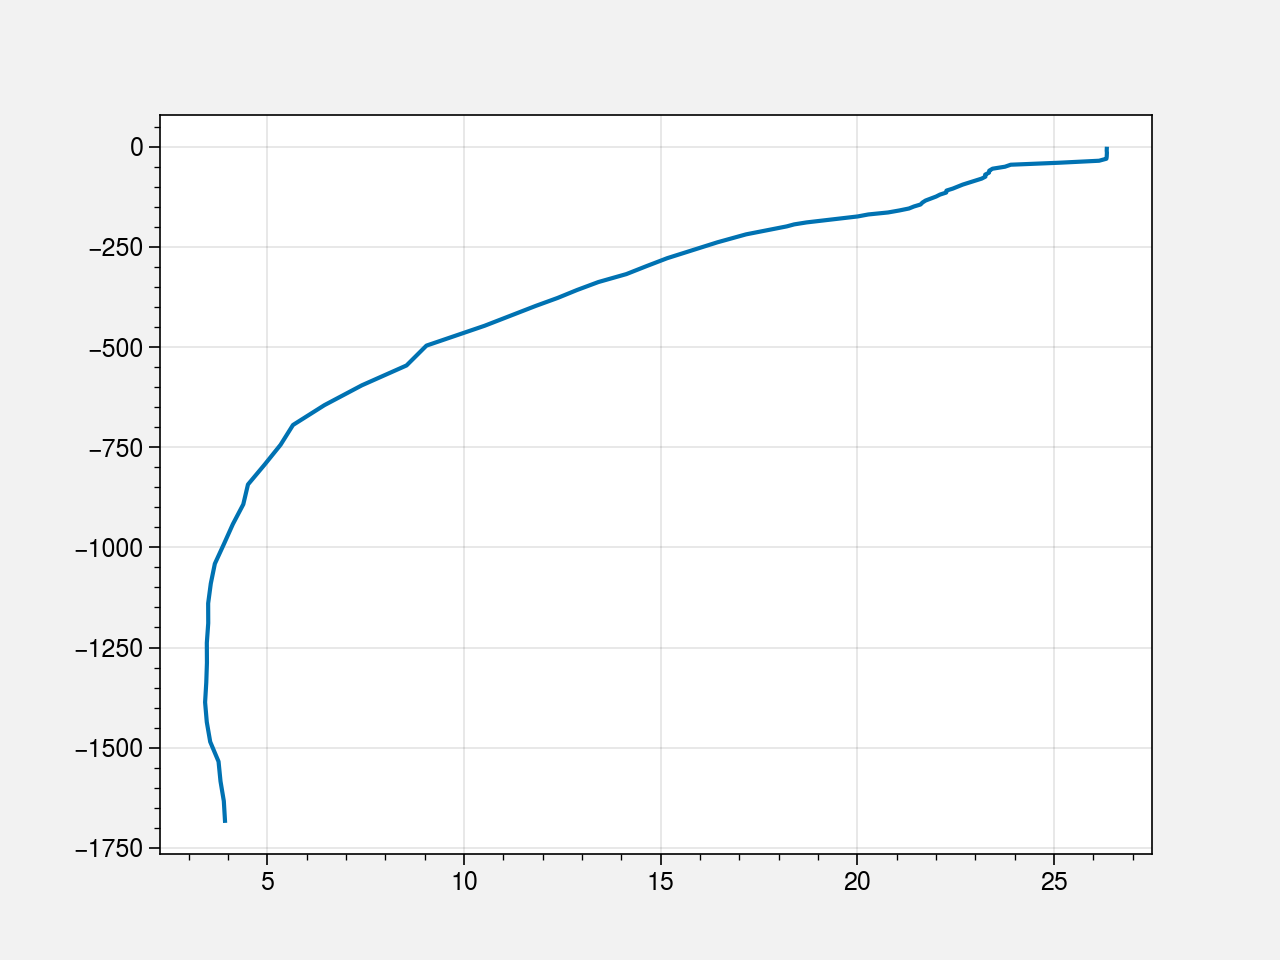

In [41]:
i_cast =500

plt.plot(CODA_test['Temperature'].isel(cast=i_cast),-CODA_test['z'].isel(cast=i_cast))

In [14]:
#point_data_container['wod_unique_cast'][i_profile] = WOD_profile_object.metadata('wod_unique_cast')
variable_attributes = WOD_profile_object.show_variable_attr('wod_unique_cast')
for i_attribute in variable_attributes:
    print(WOD_profile_object.get_variable_attr('wod_unique_cast',i_attribute))

profile_id
lat time lon


In [16]:
WOD_profile_object.metadata('crs')

In [12]:
WOD_profile_object.get_variable_attr('time',i_attribute)

'proleptic_gregorian'